Детектор аномалий на GAN c MNIST в качестве датасета аномалий

In [ ]:
from dataclasses import dataclass
from datetime import datetime

import sklearn.metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer
import os
from sklearn.manifold import TSNE

import piqa

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [ ]:
batch_size = 256

ngf = 2
ndf = 2
fuzzy_cores = 20
latent_dim = 7
niter = 300

mnist_dissident = 0

prefix = f"fuzzy_gan_anomaly_detection"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load MNIST

In [ ]:
def norm_and_transform(x):
    nimg = 2.0*(x.view(-1, 28, 28) - 0.5)
    nimg = torch.clamp(nimg, -1, 1)
    return nimg

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.RandomCrop(size=26),
    transforms.Resize(size=(28, 28)),
    transforms.Lambda(lambda x: norm_and_transform(x))
])

In [ ]:
# загружаем обучающую выборку

def get_target_and_mask(target_label):
    t = target_label
    return t 

train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)

idx = (train_data.targets != mnist_dissident)
train_data.targets = train_data.targets[idx]
train_data.data = train_data.data[idx]
len(train_data)

In [ ]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

In [ ]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)


In [ ]:
for data, label in iter(train_loader):
    plt.imshow(data[0].squeeze())
    print(data[0].max())
    print(data[0].min())
    print(label[0])
    break

## DCGAN Model

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngf, fuzzy_cores):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            
            nn.Linear(fuzzy_cores, 16*ngf),
            nn.SiLU(), 

            nn.BatchNorm1d(16*ngf),
            nn.Unflatten(1, (16*ngf, 1, 1)),
            nn.ConvTranspose2d(16*ngf, 8*ngf, 12),
            nn.SiLU(), 

            nn.BatchNorm2d(8*ngf),
            nn.ConvTranspose2d(8*ngf, 4*ngf, 5),
            nn.SiLU(), 

            nn.BatchNorm2d(4*ngf),
            nn.ConvTranspose2d(4*ngf, 2*ngf, 5),
            nn.SiLU(), 

            nn.BatchNorm2d(2*ngf),
            nn.ConvTranspose2d(2*ngf, ngf, 5),
            nn.SiLU(), 
            
            nn.BatchNorm2d(ngf),
            nn.ConvTranspose2d(ngf, 1, 5),
            nn.Tanh()
        )

    def forward(self, input):
        #fz = self.fuzzy(input)
        #fz = fz.div(fz.sum(-1).unsqueeze(-1))
        output = self.main(input.reshape((-1, fuzzy_cores)))
        return output

netG = Generator(ngf, fuzzy_cores).to(device)
netG.apply(weights_init)
num_params = sum(p.numel() for p in netG.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

print(netG)

In [ ]:
inp = torch.rand(2, fuzzy_cores).to(device)
gg = Generator(ngf, fuzzy_cores).to(device)
gg(inp)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ndf, fuzzy_cores, latent_dim):
        
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(1, ndf, kernel_size=5),
            nn.BatchNorm2d(ndf),
            nn.SiLU(),  
            nn.Conv2d(ndf, 2*ndf, kernel_size=5),
            nn.BatchNorm2d(2*ndf),
            nn.SiLU(),  
            nn.Conv2d(2*ndf, 4*ndf, kernel_size=5),
            nn.BatchNorm2d(4*ndf),
            nn.SiLU(),  
            nn.Conv2d(4*ndf, 8*ndf, kernel_size=5),
            nn.BatchNorm2d(8*ndf),
            nn.SiLU(),
            nn.Conv2d(8*ndf, 16*ndf, kernel_size=12),
            nn.BatchNorm2d(16*ndf),
            nn.Flatten(),
            nn.Linear(16*ndf, latent_dim), 
        )
        
        exp_k = 2            
        initial_centroids = exp_k * np.random.rand(fuzzy_cores, latent_dim)
        initial_scales =  exp_k * np.ones((fuzzy_cores, latent_dim))
        #initial_pow = 2 * np.ones(fuzzy_cores)
                
        self.fuzzy = FuzzyLayer.from_centers_and_scales(initial_centroids, initial_scales, trainable=True)
        
        self.defuzzy = nn.Sequential(
            DefuzzyLinearLayer.from_array(np.repeat(1.0, fuzzy_cores).reshape(1, -1), with_norm=False, trainable=False)
        )

        
    def forward(self, input):
        output = self.main(input)
        fz = self.fuzzy(output)
        r = self.defuzzy(fz)
        
        return r.squeeze(), fz, output
    

netD = Discriminator(ndf, fuzzy_cores, latent_dim).to(device)
netD.apply(weights_init)
num_params = sum(p.numel() for p in netD.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')
print(netD)

In [ ]:
inp = torch.rand(2, 1, 28, 28).to(device)
dd = Discriminator(ndf, fuzzy_cores, latent_dim).to(device)
dd(inp)

## Train

In [ ]:
optimizerD = torch.optim.Adam(netD.parameters(), lr=2e-3, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=2e-3, betas=(0.5, 0.999))
schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=50, gamma=0.5)
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=50, gamma=0.5)

fixed_noise_for_report = torch.rand(49, latent_dim, device=device)

In [ ]:
def keep_eigenvals_positive_loss(layer, eps = 1e-15):
    ev = layer.get_transformation_matrix_eigenvals().real.min()
    ev = torch.clamp(ev, max=eps)
    return -ev

In [ ]:
ssim = piqa.SSIM(window_size=11, n_channels=1, reduction='none').to(device)


def get_test_arate_distr(D, G):
    with torch.no_grad():
        firing_levels = []
        lab_true = []
        lab_pred = []

        for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
            data = data.view((-1, 1, 28, 28)).to(device)
            
            _, fz_d, _ = D(data)
            generated_image = G.main(fz_d.reshape((-1, fuzzy_cores)))
            
            diff = ssim((data + 1) / 2, (generated_image + 1) / 2)#1 - torch.cosine_similarity(data.flatten(start_dim=1), generated_image.flatten(start_dim=1))
            rates = (1 - diff).abs().detach().cpu().numpy()
            
            for f, l in  zip(rates, lab):
                firing_levels.append(f)
                lab_pred.append(f)        
                if l == mnist_dissident:
                    lab_true.append(1)
                else:
                    lab_true.append(0)
                        
        fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
        roc_auc = metrics.auc(fpr, tpr)
        firing_levels = np.array(firing_levels)
        return firing_levels, roc_auc, threshold

def draw_embeddings(netD, netG, epoch):
    with torch.no_grad():
        centroids_real = netD.fuzzy.get_centroids().detach().cpu().numpy()

        embedings_test = []
        labels_expected = []
            
        for data, target in tqdm(test_loader, desc='Encoding', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            embeding = netD.main(data)
            embedings_test.append(embeding.cpu().numpy())
            labels_expected.append(target)
        
        embedings_test = np.concatenate(embedings_test, axis=0)
        labels_expected = np.concatenate(labels_expected, axis=0)
        
        embedings_fake = []

        inp_g = netD.fuzzy(fixed_noise_for_report).detach()
        fake_images = netG(inp_g)
        embeding = netD.main(fake_images)
        embedings_fake.append(embeding.cpu().numpy())

        embedings_fake = np.concatenate(embedings_fake, axis=0)    

        fig = plt.figure(layout='constrained', figsize=(13, 4))
        subfigs = fig.subfigures(1, 3, wspace=0.07)
        axsLeft = subfigs[0].subplots(1, 1, sharey=True)

        axsLeft.scatter(embedings_test[:, 0], embedings_test[:, 1], cmap='tab10', c=labels_expected, s=1)
        axsLeft.scatter(embedings_fake[:, 0], embedings_fake[:, 1], c='purple', marker='*', s=15)
        axsLeft.scatter(centroids_real[:, 0], centroids_real[:, 1], marker='1', c='black', s= 50)
        
        axsLeft = subfigs[1].subplots(1, 1, sharey=True)
        axsLeft.scatter(embedings_test[:, 0], embedings_test[:, 2], cmap='tab10', c=labels_expected, s=1)
        axsLeft.scatter(embedings_fake[:, 0], embedings_fake[:, 2], c='purple', marker='*', s=15)
        axsLeft.scatter(centroids_real[:, 0], centroids_real[:, 2], marker='1', c='black', s= 50)
        
        fake_images_np = fake_images.cpu().detach().numpy()
        fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
        axsRight = subfigs[2].subplots(7, 7, sharey=True)
        i = 0
        for x in axsRight:
            for y in x:
                y.imshow(fake_images_np[i], cmap='gray')
                y.axis('off')
                i += 1
        plt.show()
        writer.add_figure('Embeddings', fig, epoch)

In [ ]:
netG.train()
netD.train()

#ssim_train = piqa.SSIM(window_size=5, n_channels=1, reduction='none').to(device)

writer.add_custom_scalars({'Losses': {'General': ['AUC', 'REGEN', 'FZNORM', 'G', ['POS', 'NEG'], 'EV']}})

for epoch in range(niter):
    report_aver_pos = 0
    report_aver_neg = 0
    report_loss_G = 0
    report_loss_regen = 0
    report_loss_fznorm = 0
    
    report_ev = 0
    local_count = 0
    
    for i, data in enumerate(tqdm(train_loader, desc='Training', disable=True)):
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        netD.zero_grad()
        netG.zero_grad()
        
        noise = torch.rand(batch_size, latent_dim, device=device)
        inp_g = netD.fuzzy(noise).detach()
        fake = netG(inp_g)
        
        firing_r, fz_infer, _ = netD(real_cpu)
        limit_real = (1.00 + 0.02 * (1 - 2*torch.rand(batch_size))).to(device)
        errD_real = torch.square(limit_real - firing_r).mean() 
        errD_real.backward(retain_graph=True)

        fz_norm = (1 - fz_infer.sum(-1)).square().mean()
        fz_norm.backward(retain_graph=True)
        
        nfiring_r, _, _ = netD(fake.detach())
        errD_fake = (nfiring_r).square().mean()
        errD_fake.backward()
        
        ev_loss = keep_eigenvals_positive_loss(netD.fuzzy)
        report_ev = np.maximum(report_ev, ev_loss.item())
        if ev_loss.item() > 0:
            ev_loss.backward()
        
        optimizerD.step()
        
        fz_genr,_, _ = netD(fake)
        errG = (1 - fz_genr).square().mean()
        errG.backward()
        
        optimizerG.step()
        
        _, fz_d_real, _ = netD(real_cpu)
        regen = netG(fz_d_real)
        
        regen_loss = (real_cpu - regen).square().sum(-1).sum(-1).mean()#(1-ssim_train((real_cpu + 1)/2, (regen + 1)/2)).abs().mean() #
        regen_loss.backward()
        optimizerG.step()
        optimizerD.step()    
        report_loss_regen += regen_loss.item()

        local_count += 1
        report_loss_G += errG.item()
        report_aver_pos += firing_r.mean().item()
        report_aver_neg += nfiring_r.mean().item()
        report_loss_fznorm += fz_norm.item()
        
    with torch.no_grad():
        
        if epoch % 3 == 0:
            firings, auc, threshold = get_test_arate_distr(netD, netG)
            writer.add_scalar('AUC', auc, epoch)
            draw_embeddings(netD, netG, epoch)
            print(f"Epoch {epoch}/{niter} AUC {auc}")

        writer.add_scalar('MISC/G', report_loss_G / local_count, epoch)
        writer.add_scalar('POSNEG/POS', report_aver_pos / local_count, epoch)
        writer.add_scalar('POSNEG/NEG', report_aver_neg / local_count, epoch)
        writer.add_scalar('MISC/EV', report_ev, epoch)
        writer.add_scalar('MISC/REGEN', report_loss_regen / local_count, epoch)
        writer.add_scalar('MISC/FZNORM', report_loss_fznorm / local_count, epoch)
        
        
    schedulerD.step()
    schedulerG.step()
    

In [ ]:
torch.save(netD.state_dict(), f'weights/netD_{mnist_dissident}.pth')
torch.save(netG.state_dict(), f'weights/netG_{mnist_dissident}.pth')

## Валидация

In [ ]:
D = Discriminator(ndf, fuzzy_cores, latent_dim).to(device)
G = Generator(ngf, fuzzy_cores).to(device)
D.load_state_dict(torch.load(f'weights/netD_{mnist_dissident}.pth'))
G.load_state_dict(torch.load(f'weights/netG_{mnist_dissident}.pth'))

#D.eval()
#G.eval()

In [ ]:
draw_embeddings(D, G, niter)

In [ ]:
firings, auc, threshold = get_test_arate_distr(D,G)
print(F"Average firing {firings.mean()}")
print(F"AUC {auc} Threshold {threshold}")


In [ ]:
# with torch.no_grad():
#     R, C = 10, 10
#     x = np.linspace(0.0, 1.0, R*C)
#     y = 0.3*x+0.7

#     noise = torch.FloatTensor(np.dstack((x,y))).reshape((-1,nz)).to(device)
#     fake_images, _ = G(noise)
#     fake_images_np = fake_images.cpu().detach().numpy()
#     fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
    
#     embedings = D.main(fake_images).cpu().numpy()
        
    
#     for i in range(R*C):
#         plt.subplot(R, C, i + 1)
#         plt.imshow(fake_images_np[i], cmap='gray')
#     plt.show()
#     plt.scatter(embedings[:,0],embedings[:,1], s=2)

In [ ]:
with torch.no_grad():
    
    noise = torch.rand(49, latent_dim, device=device)
    inp_g = netD.fuzzy(noise).detach()
    fake_images = netG(inp_g)

    fake_images_np = fake_images.cpu().detach().numpy()
    fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
    R, C = 7, 7
    for i in range(49):
        plt.subplot(R, C, i + 1)
        plt.imshow(fake_images_np[i], cmap='gray')
    plt.show()

In [51]:
def get_arate(inp):
    _, fz_d, _ = D(inp)
    generated_image = G.main(fz_d.reshape((-1, fuzzy_cores)))
    _, fz_d, _ = D(generated_image)
    generated_image = G.main(fz_d.reshape((-1, fuzzy_cores)))
    
    
    diff = ssim((inp+1)/2, (generated_image+1)/2)#1 - torch.cosine_similarity(data.flatten(start_dim=1), generated_image.flatten(start_dim=1))
    rates = (1-diff).abs().detach().cpu().numpy()
    #rates = torch.where(diff > 0.5, 1.0, 0.0).mean(-1).mean(-1).squeeze()
    #diff = (inp-generated_image).squeeze().sum(-1).sum(-1)
    #rates = diff.detach().cpu().numpy()
    
    
    return rates#(1-fz_d.sum(-1)).abs().detach().cpu().numpy() #torch.square(fz_d - fz_g).sum(-1).detach().cpu().numpy()#fz_d.max(-1).values.detach().cpu().numpy() ##torch.cosine_similarity(fz_d, fz_g, dim=-1).detach().cpu().numpy()#(rd+rg-rd*rg).detach().cpu().numpy()#torch.square(embd1 - embd2).sum(-1).detach().cpu().numpy()# # # #

inp = torch.rand((10,1,28,28))
get_arate(inp.to(device))

array([0.9863268, 0.9830929, 0.9801133, 1.002928 , 0.9972209, 1.0291275,
       0.9568912, 0.9590894, 0.9683522, 1.0144894], dtype=float32)

In [52]:
centroids_r = D.fuzzy.get_centroids().detach().cpu().numpy()
centroids_r

array([[ 5.02223206e+01,  1.83191471e+01,  3.34756203e+01,
         2.06052990e+01,  3.08257351e+01,  2.75418892e+01,
         3.79468346e+01],
       [ 2.45392838e+02,  1.01625153e+02,  7.89399033e+01,
         3.63925415e+02,  9.08958511e+01,  2.91702240e+02,
         1.71909225e+02],
       [ 2.82708287e+00,  2.05014777e+00,  2.44012237e+00,
         1.07839942e+00,  4.20130730e+00,  3.06579208e+00,
         9.58802938e-01],
       [ 1.12649357e+00,  2.89028335e+00,  1.64110374e+00,
         1.51209867e+00,  1.82662094e+00,  8.86639833e-01,
         5.05277634e-01],
       [ 2.88444405e+01,  2.35976219e+01, -1.06501694e+01,
         1.63471470e+01,  2.07959938e+01,  1.90512962e+01,
         8.78429222e+00],
       [ 4.34868622e+00,  3.66265869e+00,  4.29222918e+00,
         1.70677738e+01,  1.28584385e+01,  1.78768635e+01,
         1.29920120e+01],
       [ 7.32000122e+02,  2.86307617e+02,  3.40814331e+02,
         2.18938110e+02,  2.43650391e+02,  3.19841156e+02,
         1.7270950

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

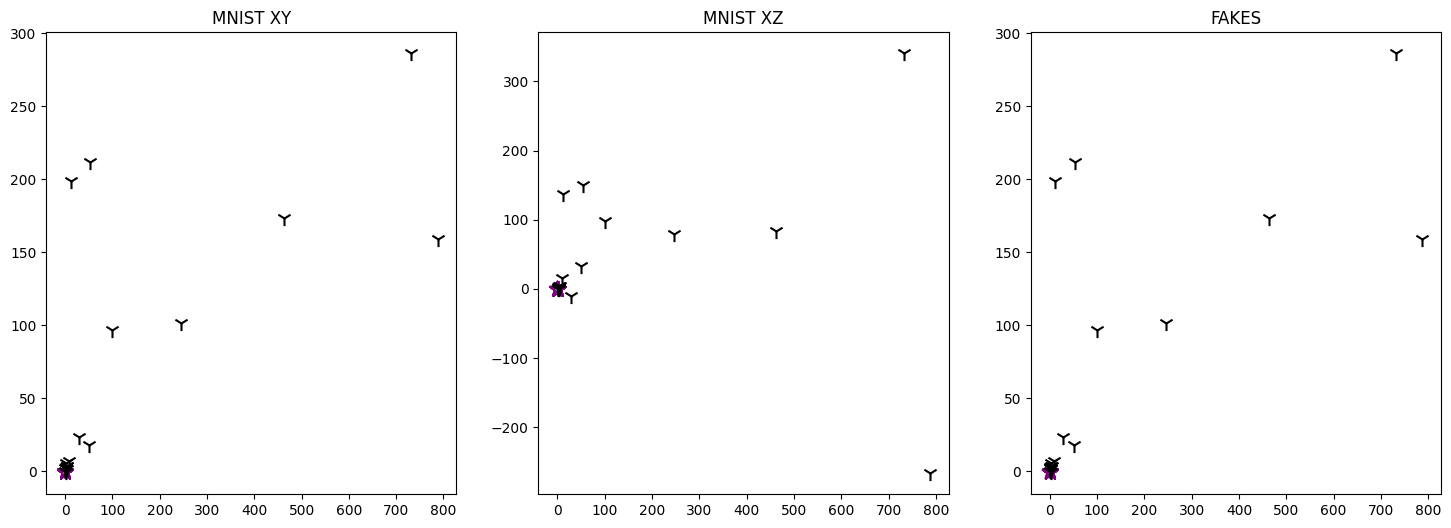

In [53]:
embedings_fake = []

with torch.no_grad():
    batch_size = 256
    
    inp_g = netD.fuzzy(fixed_noise_for_report).detach()
    fake_images = G(inp_g)
    
    embeding = D.main(fake_images)
    embedings_fake.append(embeding.cpu().numpy())

embedings_fake = np.concatenate(embedings_fake, axis=0)    

embedings = []
labels_expected = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        embeding = D.main(data)
        embedings.append(embeding.cpu().numpy())
        labels_expected.append(target.cpu().numpy())
embedings = np.concatenate(embedings, axis=0)
labels_expected = np.concatenate(labels_expected, axis=0)

plt.figure(figsize=(18, 6))

R, C = 1, 3

plt.subplot(R, C, 1)
plt.title("MNIST XY")
plt.scatter(embedings_fake[:, 0], embedings_fake[:, 1], c='purple', marker='*', s=120)
plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap='tab10', s=2)
plt.scatter(centroids_r[:, 0],    centroids_r[:,1], marker='1', c='black', s= 120)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.subplot(R, C, 2)
plt.title("MNIST XZ")
plt.scatter(embedings_fake[:, 0], embedings_fake[:, 2], c='purple', marker='*', s=120)
plt.scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap='tab10', s=2)
plt.scatter(centroids_r[:, 0],    centroids_r[:,2], marker='1', c='black', s= 120)

plt.subplot(R, C, 3)
plt.title("FAKES")
plt.scatter(embedings_fake[:, 0], embedings_fake[:, 1], c='purple', marker='*', s=120)
plt.scatter(centroids_r[:, 0], centroids_r[:, 1], marker='1', c='black', s= 120)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

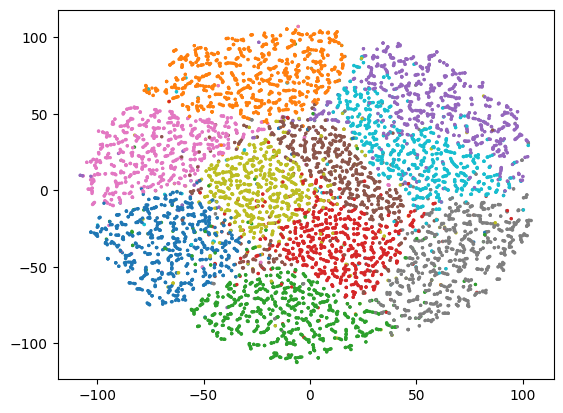

In [54]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(embedings)
plt.scatter(X_embedded[:, 0],      X_embedded[:,  1], c=labels_expected, cmap='tab10', s=2)

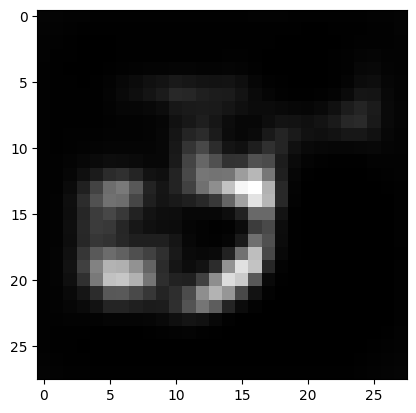

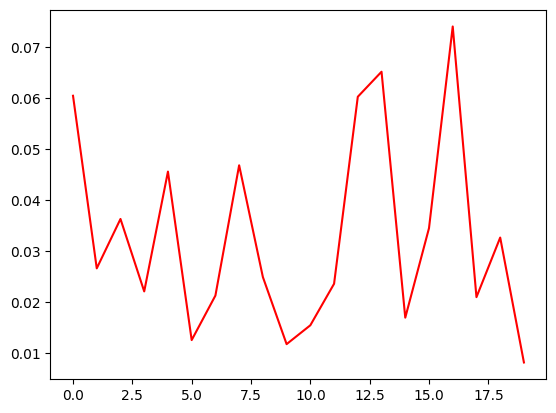

In [55]:
fixed_noise = torch.rand(2, latent_dim)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
inp_g = D.fuzzy(fixed_noise).detach()
#inp_g = inp_g.reshape(fuzzy_cores)
fake_images = G(inp_g)


_, fzd,_ = D(fake_images)
fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
plt.imshow(fake_images_np[0], cmap='gray')
plt.show()
plt.plot(fzd[0].detach().cpu().numpy(), c="red")

MNIST HIST:   0%|          | 0/40 [00:00<?, ?it/s]

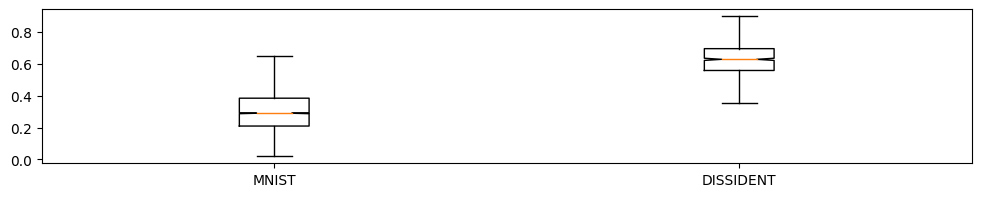

In [56]:
firings_mnist = {}
firings_mnist['MNIST'] = []
firings_mnist['DISSIDENT'] = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='MNIST HIST'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        for f, l in  zip(rates, target):
            if l != mnist_dissident:
                firings_mnist['MNIST'].append(f)
            else:
                firings_mnist['DISSIDENT'].append(f)
        

labels, data = firings_mnist.keys(), firings_mnist.values()

fig = plt.figure(figsize =(12, 2))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

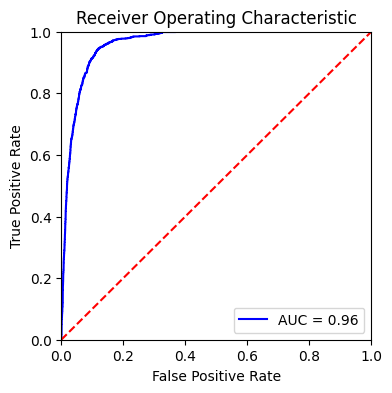

In [57]:
with torch.no_grad():
    firing_levels = []
    lab_true = []
    lab_pred = []

    for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        
        for f, l in  zip(rates, lab):
            firing_levels.append(f)
            lab_pred.append(f)        
            if l == mnist_dissident:
                lab_true.append(1)
            else:
                lab_true.append(0)
                    
    fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    fig = plt.figure(figsize =(4, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    writer.add_figure('ROC', fig)

In [58]:
def find_best_binary_auc_threshold(binary_thresholds,
                               fp_rate,
                               recall,
                               proportion_positive_case: float = 0.5,
                               cost_false_positive: float = 0.5,
                               cost_false_negative: float = 0.5,
                               argmin_axis: int = 0):
    isocost_lines = cost_false_positive * (1 - proportion_positive_case) * fp_rate + cost_false_negative * proportion_positive_case * (1 - recall)
    best_indexes = np.argmin(isocost_lines, axis=argmin_axis)
    best_thresholds = binary_thresholds[best_indexes.tolist()]
    return best_thresholds, best_indexes

th_optimal, _ = find_best_binary_auc_threshold(threshold, fpr, tpr, proportion_positive_case=0.1)
print(f"Optimal threshold {th_optimal}")

Optimal threshold 0.5968872904777527


Anomaly : [ True  True] ([0.947044  0.9492938]/0.5968872904777527)


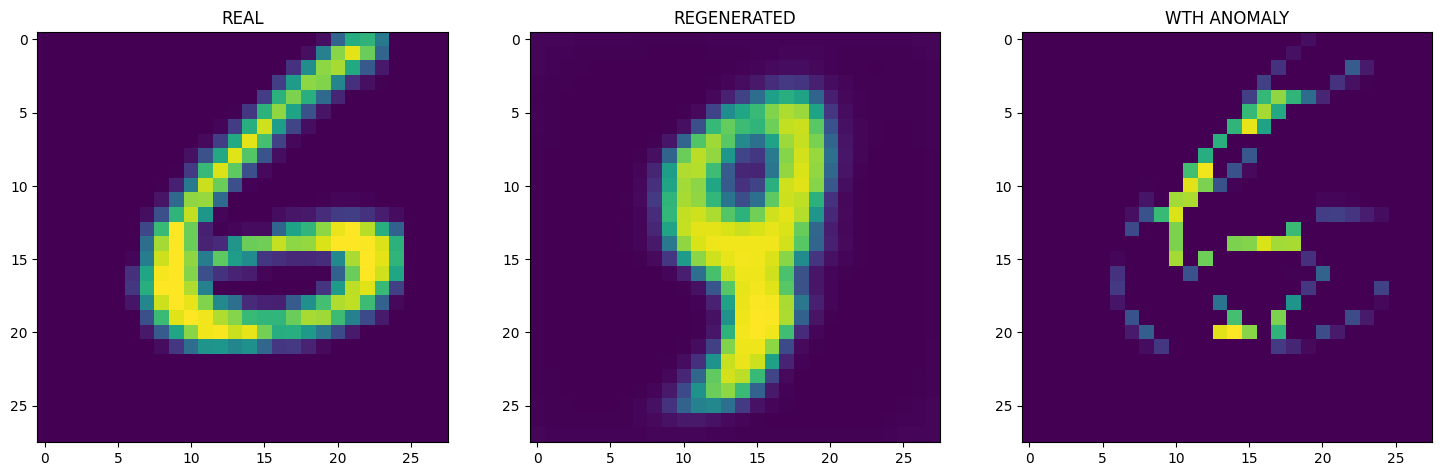

In [89]:

with torch.no_grad():
    img = test_loader.dataset[161][0].view((-1, 1, 28, 28)).to(device)
    img  = torch.cat((img,img))

    r, fzd, _ = D(img)
    gimg = G.main(fzd.reshape((-1, fuzzy_cores)))

    diff = (img[0][0] - gimg[0][0]).abs()
    anodet = torch.where(diff > 0.6, -1, img[0][0])

    plt.figure(figsize=(18, 6))

    R, C = 1, 3

    plt.subplot(R, C, 1)
    plt.title("REAL")
    plt.imshow(img[0][0].detach().cpu().numpy())
    plt.subplot(R, C, 2)
    plt.title("REGENERATED")
    plt.imshow(gimg[0][0].detach().cpu().numpy())
    plt.subplot(R, C, 3)
    plt.title("WTH ANOMALY")
    plt.imshow(anodet.detach().cpu().numpy())
    arate = get_arate(img)
    print(F"Anomaly : {arate > th_optimal} ({arate}/{th_optimal})")


tensor([0.7918, 0.7918], device='cuda:0')

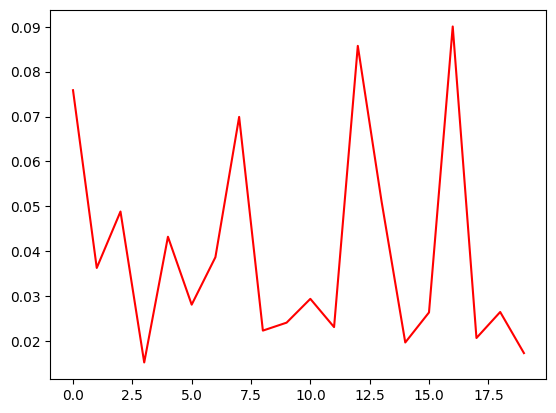

In [90]:
plt.plot(fzd[0].detach().cpu().numpy(), c="red")
#plt.plot(fzg[0].detach().cpu().numpy(), c="blue")
fzd.sum(-1)

EMNIST VIS:   0%|          | 0/40 [00:00<?, ?it/s]

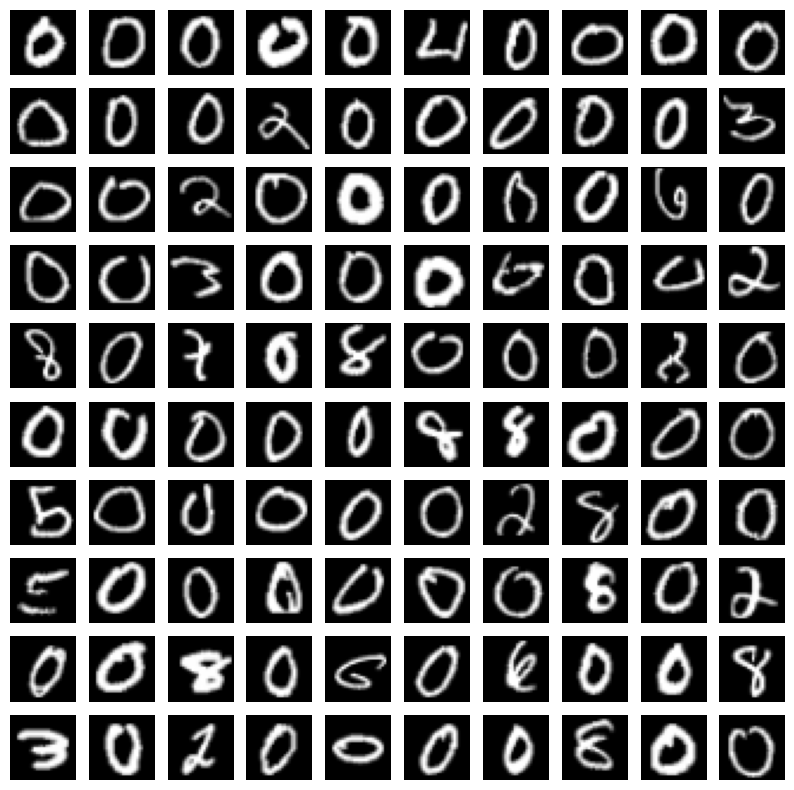

In [91]:
n = 0
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
with torch.no_grad():
    for data, labels in tqdm(test_loader, desc='EMNIST VIS'):
        if n >= 100:
            break
        data = data.view((-1, 1, 28, 28)).to(device) 
        
        arate = get_arate(data)
        
        for i in range(data.shape[0]):
            if(arate[i] > th_optimal):
                img = data[i]
                ax[int(n / 10), int(n % 10)].imshow(img.view(28, 28).cpu().detach().numpy(), cmap='gray')
                ax[int(n / 10), int(n % 10)].axis('off')
                n = n + 1
                    
                if n >= 100:
                    break